Modelling StandardScaler

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,28102,172.16.0.5-192.168.50.1-553-11930-17,172.16.0.5,553,192.168.50.1,11930,17,2018-12-01 11:23:04.133911,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
1,17675,172.16.0.5-192.168.50.1-997-4051-17,172.16.0.5,997,192.168.50.1,4051,17,2018-12-01 11:32:18.205323,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
2,661545,172.16.0.5-192.168.50.1-27238-3411-6,172.16.0.5,27238,192.168.50.1,3411,6,2018-12-01 13:31:10.155752,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
3,688385,172.16.0.5-192.168.50.1-36181-39435-6,172.16.0.5,36181,192.168.50.1,39435,6,2018-12-01 13:30:48.279274,51,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
4,16016,172.16.0.5-192.168.50.1-35261-14404-17,172.16.0.5,35261,192.168.50.1,14404,17,2018-12-01 13:02:49.155721,105961,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [6]:
df.describe()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,360000.000000,360000.000000,3.600000e+05,3.600000e+05,360000.000000,...,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000
mean,91493.758128,26078.477756,30912.601833,14.700269,2.200160e+06,8.975250,0.585044,3.733058e+03,3.847677e+02,582.758328,...,-3.609785e+07,7.325171e+03,2.620700e+03,1.084865e+04,5.733338e+03,6.801519e+05,1.105356e+05,8.047233e+05,5.820746e+05,0.930525
std,135889.709116,25364.107740,20110.524442,4.502866,1.275317e+07,250.280517,12.328315,3.287519e+04,3.131816e+04,544.547707,...,1.925211e+08,1.685573e+05,7.402011e+04,2.224704e+05,1.570655e+05,4.457633e+06,1.025535e+06,5.103451e+06,4.112389e+06,0.254261
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,11986.000000,771.000000,13028.000000,17.000000,1.000000e+00,2.000000,0.000000,4.580000e+02,0.000000e+00,229.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,38063.500000,21346.500000,30909.000000,17.000000,2.000000e+00,2.000000,0.000000,1.088000e+03,0.000000e+00,415.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,106306.000000,52107.250000,48665.000000,17.000000,1.821250e+03,4.000000,0.000000,2.944000e+03,0.000000e+00,1035.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,805151.000000,65534.000000,65535.000000,17.000000,1.200000e+08,86220.000000,4602.000000,1.526642e+07,8.818824e+06,32120.000000,...,1.480000e+03,1.721058e+07,2.284064e+07,4.358468e+07,1.310114e+07,1.058368e+08,6.600292e+07,1.058368e+08,1.058368e+08,1.000000


In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

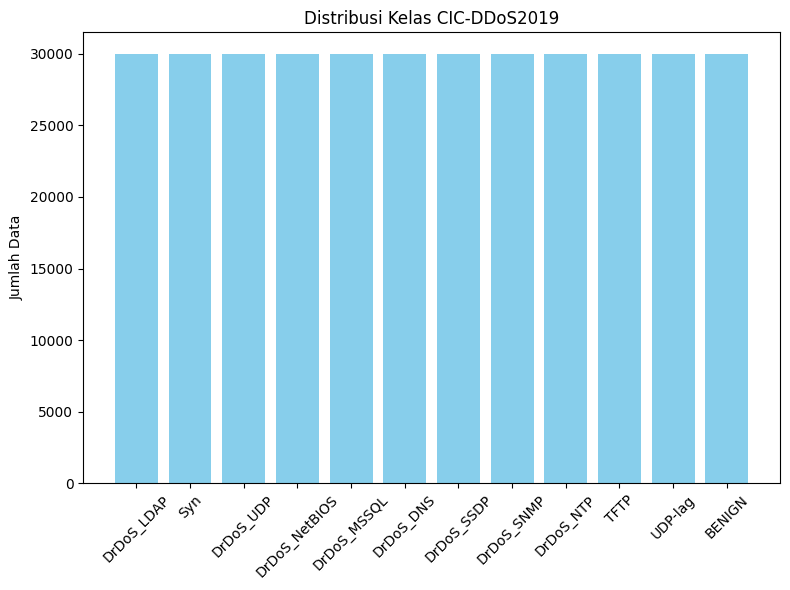

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Kelas CIC-DDoS2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

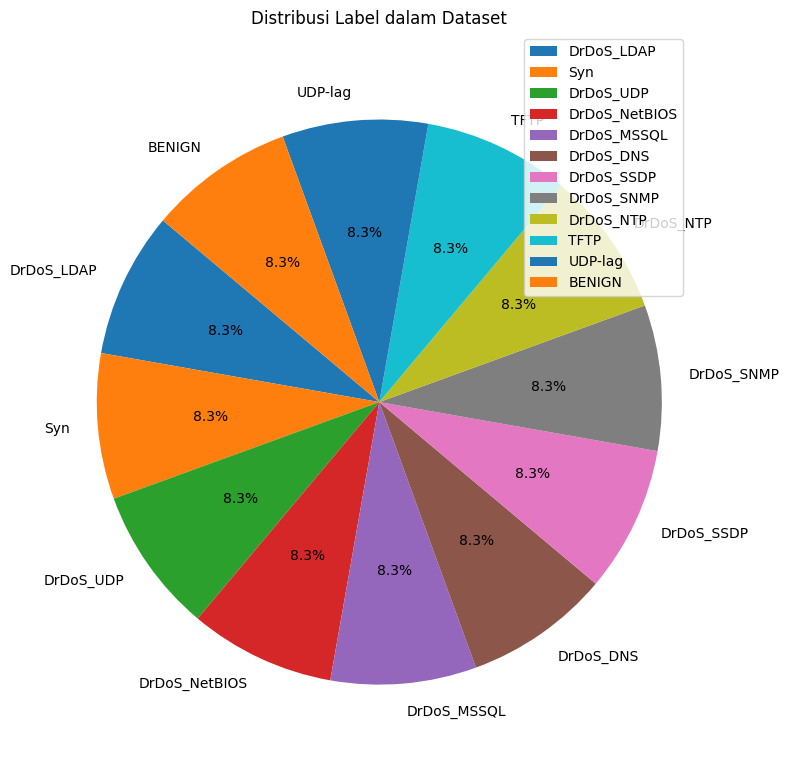

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

,Label
0,2
1,2
2,9
3,9
4,8


### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Modeling without Feature Selection -- StandarScaler

#### StandarScaler

In [16]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Buat transformer untuk masing-masing tipe fitur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),   # Standarisasi untuk fitur numerik
        ('cat', 'passthrough', categorical_features)     # Lewatkan fitur kategori tanpa diubah
    ])

# Fit dan transform sekaligus
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [17]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

#### Algoritma Individual StandarScaler

##### GBC

Waktu pelatihan (Gradient Boosting): 1098.2618 detik
Waktu prediksi (Gradient Boosting): 3.3319 detik


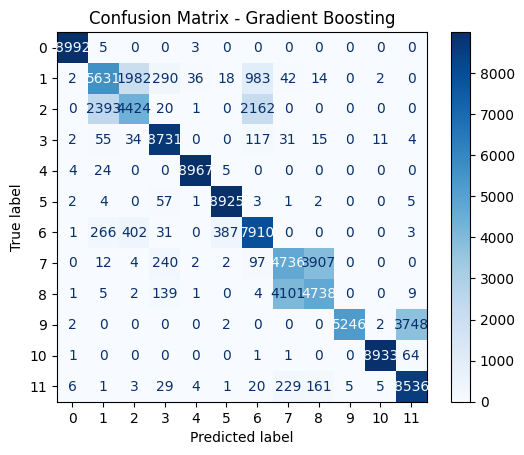

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.65      0.49      0.56      9000
           3       0.92      0.97      0.94      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.53      0.52      9000
           8       0.54      0.53      0.53      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [50]:
# GBC
start_train = time.time()

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Gradient Boosting): {training_time:.4f} detik")

evaluate_model(gbc, X_test_scaled, y_test, name="Gradient Boosting")

##### MLP

Iteration 1, loss = 0.87214211
Iteration 2, loss = 0.63772893
Iteration 3, loss = 0.58976777
Iteration 4, loss = 0.56572296
Iteration 5, loss = 0.55275763
Iteration 6, loss = 0.54420184
Iteration 7, loss = 0.53699379
Iteration 8, loss = 0.53200752
Iteration 9, loss = 0.52864702
Iteration 10, loss = 0.52503774
Iteration 11, loss = 0.52146351
Iteration 12, loss = 0.51918990
Iteration 13, loss = 0.51708034
Iteration 14, loss = 0.51451726
Iteration 15, loss = 0.51315157
Iteration 16, loss = 0.51067445
Iteration 17, loss = 0.50913991
Iteration 18, loss = 0.50714006
Iteration 19, loss = 0.50600968
Iteration 20, loss = 0.50389136
Iteration 21, loss = 0.50235106
Iteration 22, loss = 0.49999569
Iteration 23, loss = 0.49954472
Iteration 24, loss = 0.49768377
Iteration 25, loss = 0.49611854
Iteration 26, loss = 0.49526887
Iteration 27, loss = 0.49257084
Iteration 28, loss = 0.49122758
Iteration 29, loss = 0.48996128
Iteration 30, loss = 0.48941213
Iteration 31, loss = 0.48853004
Iteration 32, los

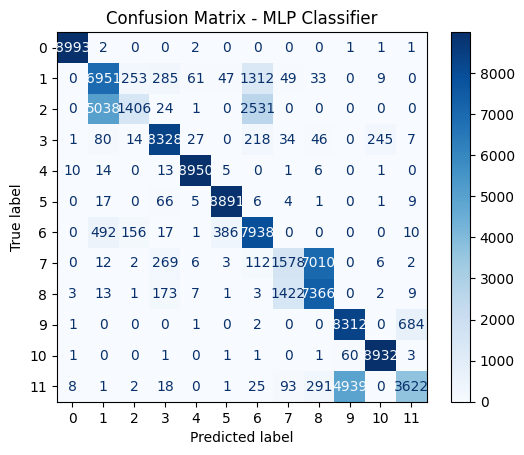

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.77      0.64      9000
           2       0.77      0.16      0.26      9000
           3       0.91      0.93      0.92      9000
           4       0.99      0.99      0.99      9000
           5       0.95      0.99      0.97      9000
           6       0.65      0.88      0.75      9000
           7       0.50      0.18      0.26      9000
           8       0.50      0.82      0.62      9000
           9       0.62      0.92      0.75      9000
          10       0.97      0.99      0.98      9000
          11       0.83      0.40      0.54      9000

    accuracy                           0.75    108000
   macro avg       0.77      0.75      0.72    108000
weighted avg       0.77      0.75      0.72    108000



In [19]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(random_state=42, verbose=True)

mlp.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test_scaled, y_test, name="MLP Classifier")

Iteration 1, loss = 0.68995017
Validation score: 0.724921
Iteration 2, loss = 0.54369092
Validation score: 0.742698
Iteration 3, loss = 0.51745956
Validation score: 0.742619
Iteration 4, loss = 0.50559828
Validation score: 0.751905
Iteration 5, loss = 0.49591413
Validation score: 0.745000
Iteration 6, loss = 0.49014544
Validation score: 0.753214
Iteration 7, loss = 0.48607658
Validation score: 0.749762
Iteration 8, loss = 0.48142206
Validation score: 0.765397
Iteration 9, loss = 0.48004697
Validation score: 0.756032
Iteration 10, loss = 0.47763109
Validation score: 0.764286
Iteration 11, loss = 0.47526149
Validation score: 0.760952
Iteration 12, loss = 0.47390092
Validation score: 0.764643
Iteration 13, loss = 0.47318820
Validation score: 0.758532
Iteration 14, loss = 0.47229916
Validation score: 0.750317
Iteration 15, loss = 0.47087839
Validation score: 0.755198
Iteration 16, loss = 0.46790058
Validation score: 0.756944
Iteration 17, loss = 0.46769830
Validation score: 0.768849
Iterat

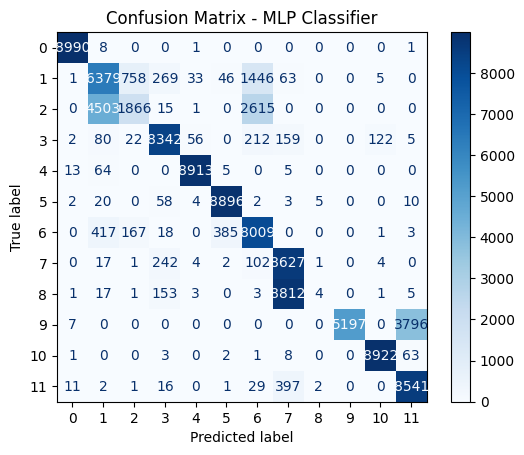

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.71      0.62      9000
           2       0.66      0.21      0.32      9000
           3       0.92      0.93      0.92      9000
           4       0.99      0.99      0.99      9000
           5       0.95      0.99      0.97      9000
           6       0.64      0.89      0.75      9000
           7       0.48      0.96      0.64      9000
           8       0.33      0.00      0.00      9000
           9       1.00      0.58      0.73      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.73    108000
weighted avg       0.77      0.77      0.73    108000



In [46]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test_scaled, y_test, name="MLP Classifier")

##### KNN

Waktu pelatihan (KNN): 0.1191 detik
Waktu prediksi (KNN): 51.9736 detik


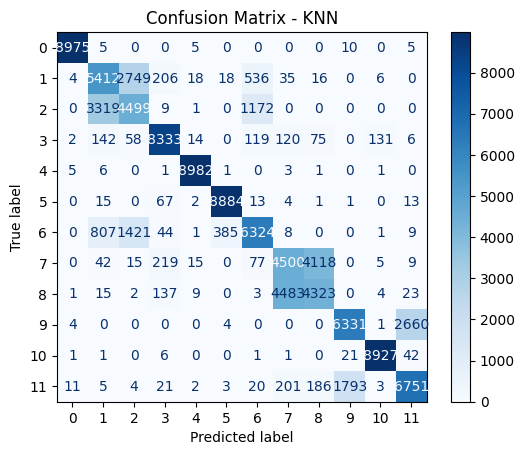

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.92      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.50      0.48      0.49      9000
           9       0.78      0.70      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [21]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_scaled, y_test, name="KNN")

Waktu pelatihan (KNN): 0.0634 detik
Waktu prediksi (KNN): 23.9254 detik


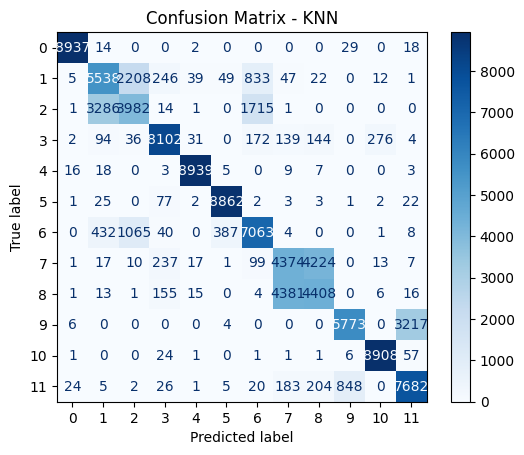

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.59      0.62      0.60      9000
           2       0.55      0.44      0.49      9000
           3       0.91      0.90      0.90      9000
           4       0.99      0.99      0.99      9000
           5       0.95      0.98      0.97      9000
           6       0.71      0.78      0.75      9000
           7       0.48      0.49      0.48      9000
           8       0.49      0.49      0.49      9000
           9       0.87      0.64      0.74      9000
          10       0.97      0.99      0.98      9000
          11       0.70      0.85      0.77      9000

    accuracy                           0.76    108000
   macro avg       0.77      0.76      0.76    108000
weighted avg       0.77      0.76      0.76    108000



In [39]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_scaled, y_test, name="KNN")

##### RF

Waktu pelatihan (Random Forest): 47.9394 detik
Waktu prediksi (Random Forest): 2.7083 detik


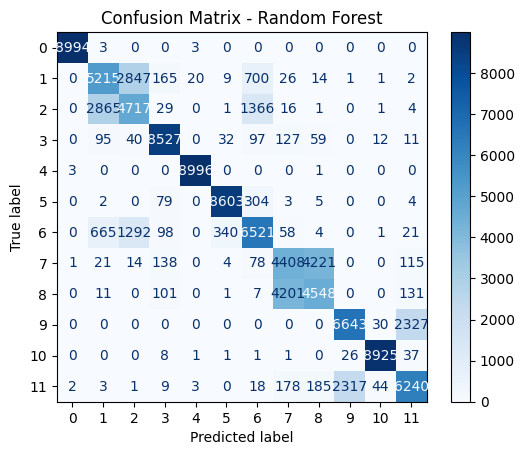

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.58      0.58      9000
           2       0.53      0.52      0.53      9000
           3       0.93      0.95      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.96      0.96      9000
           6       0.72      0.72      0.72      9000
           7       0.49      0.49      0.49      9000
           8       0.50      0.51      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.69      0.70      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [40]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_scaled, y_test, name="Random Forest")

##### Logistic Regression

Waktu pelatihan (Logistic Regression): 362.6485 detik
Waktu prediksi (Logistic Regression): 0.0240 detik


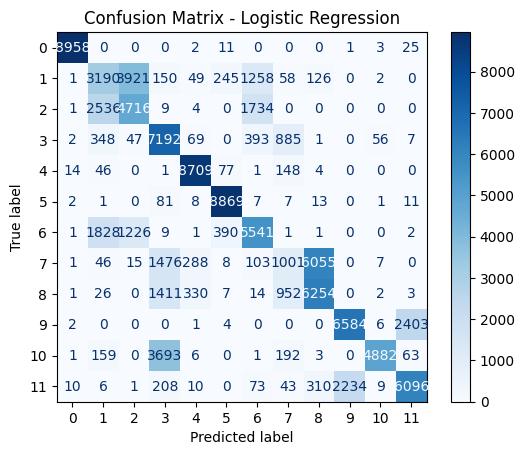

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.39      0.35      0.37      9000
           2       0.48      0.52      0.50      9000
           3       0.51      0.80      0.62      9000
           4       0.92      0.97      0.94      9000
           5       0.92      0.99      0.95      9000
           6       0.61      0.62      0.61      9000
           7       0.30      0.11      0.16      9000
           8       0.49      0.69      0.57      9000
           9       0.75      0.73      0.74      9000
          10       0.98      0.54      0.70      9000
          11       0.71      0.68      0.69      9000

    accuracy                           0.67    108000
   macro avg       0.67      0.67      0.65    108000
weighted avg       0.67      0.67      0.65    108000



In [20]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_scaled, y_test, name="Logistic Regression")

##### XGB

Waktu pelatihan (XGBoost): 10.7684 detik
Waktu prediksi (XGBoost): 0.2261 detik


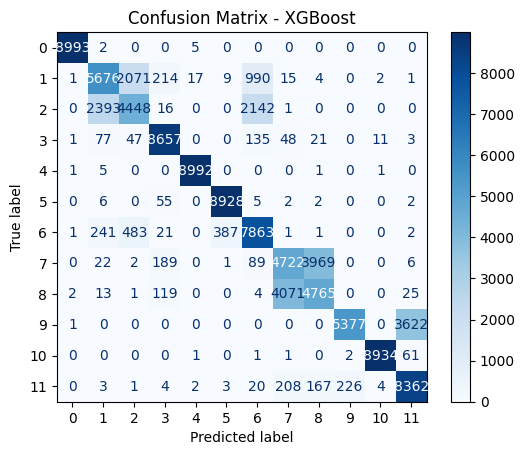

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.49      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [42]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_scaled, y_test, name="XGBoost")

##### SVM

Waktu pelatihan (SVM): 2364.6878 detik
Waktu prediksi (SVM): 1873.1152 detik


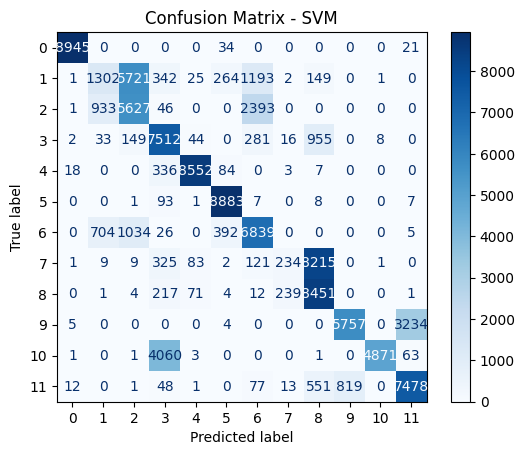

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9000
           1       0.44      0.14      0.22      9000
           2       0.45      0.63      0.52      9000
           3       0.58      0.83      0.68      9000
           4       0.97      0.95      0.96      9000
           5       0.92      0.99      0.95      9000
           6       0.63      0.76      0.69      9000
           7       0.46      0.03      0.05      9000
           8       0.46      0.94      0.62      9000
           9       0.88      0.64      0.74      9000
          10       1.00      0.54      0.70      9000
          11       0.69      0.83      0.76      9000

    accuracy                           0.69    108000
   macro avg       0.71      0.69      0.66    108000
weighted avg       0.71      0.69      0.66    108000



In [18]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_scaled, y_test, name="SVM")

##### NB

Waktu pelatihan (Naive Bayes): 0.4207 detik
Waktu prediksi (Naive Bayes): 0.8955 detik


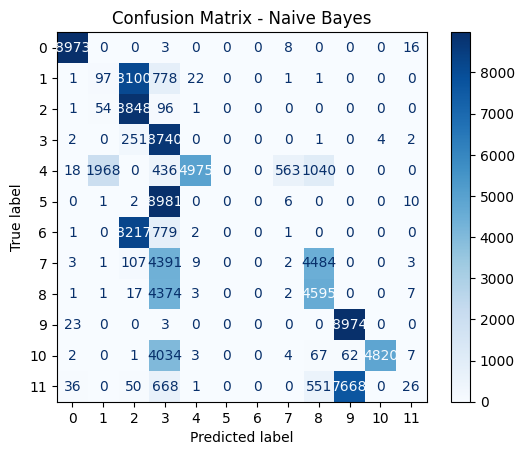

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9000
           1       0.05      0.01      0.02      9000
           2       0.35      0.98      0.51      9000
           3       0.26      0.97      0.41      9000
           4       0.99      0.55      0.71      9000
           5       0.00      0.00      0.00      9000
           6       0.00      0.00      0.00      9000
           7       0.00      0.00      0.00      9000
           8       0.43      0.51      0.47      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.37      0.00      0.01      9000

    accuracy                           0.46    108000
   macro avg       0.41      0.46      0.38    108000
weighted avg       0.41      0.46      0.38    108000



In [43]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_scaled, y_test, name="Naive Bayes")

##### DT

Waktu pelatihan (Decision Tree): 5.2523 detik
Waktu prediksi (Decision Tree): 0.0577 detik


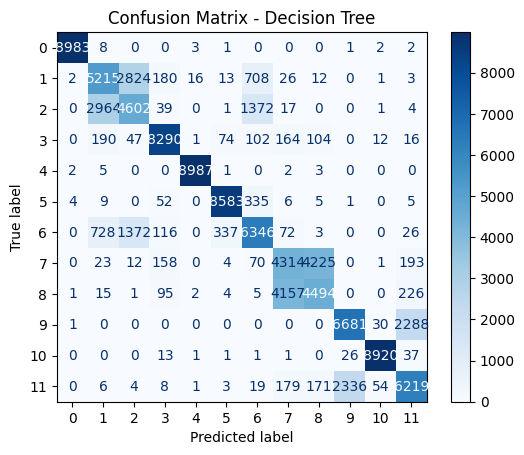

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.57      0.58      0.57      9000
           2       0.52      0.51      0.52      9000
           3       0.93      0.92      0.92      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.71      0.71      9000
           7       0.48      0.48      0.48      9000
           8       0.50      0.50      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [44]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier()
dt = dt.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_scaled, y_test, name="Decision Tree")

##### AdaBoost

Waktu pelatihan (AdaBoost): 23.5645 detik
Waktu prediksi (AdaBoost Classifier): 1.5333 detik


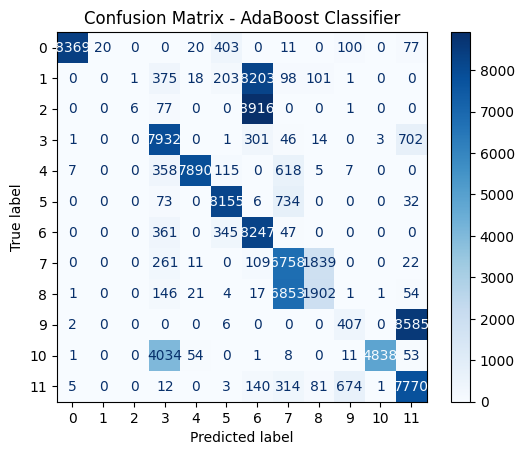

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9000
           1       0.00      0.00      0.00      9000
           2       0.86      0.00      0.00      9000
           3       0.58      0.88      0.70      9000
           4       0.98      0.88      0.93      9000
           5       0.88      0.91      0.89      9000
           6       0.32      0.92      0.47      9000
           7       0.44      0.75      0.55      9000
           8       0.48      0.21      0.29      9000
           9       0.34      0.05      0.08      9000
          10       1.00      0.54      0.70      9000
          11       0.45      0.86      0.59      9000

    accuracy                           0.58    108000
   macro avg       0.61      0.58      0.51    108000
weighted avg       0.61      0.58      0.51    108000



In [45]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_scaled, y_test, name="AdaBoost Classifier")